In [3]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from numpy.linalg import norm
from tqdm import tqdm
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
import torch, torchvision
assert torch.__version__.startswith("1.7")
import detectron2
import json
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import glob
import matplotlib.pyplot as plt
# from .detectron2.tools.train_net import Trainer
from detectron2.engine import DefaultTrainer
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from annoy import AnnoyIndex
import random
import warnings


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05



cfg.MODEL.MASK_ON = False
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

cfg.MODEL.DEVICE='cpu'
cfg.MODEL.WEIGHTS = os.path.join("model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")
classes = {1:"chair", 2:'clock', 3:'couch', 4:'lamp',5:'potted plant',6:'table'}

def final_model(img_path="datas/room_2.jpg",thresh=0.5,category_list=('couch','table','chair')):
    warnings.filterwarnings("ignore")
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    img_name = img_path[5:-4]
    im = cv2.imread(img_path)
    outputs = predictor(im)
    img_data = outputs['instances']
    box_array = img_data.get_fields()['pred_boxes'].tensor.numpy()
    class_array = img_data.get_fields()['pred_classes'].numpy()
    for num in range(len(box_array)):
        print(f'{num}. ' + classes[class_array[num]])
        x0 = int(box_array[num][0])
        y0 = int(box_array[num][1])
        x1 = int(box_array[num][2])
        y1 = int(box_array[num][3])
        im1 = im[y0:y1 , x0:x1, :]
        plt.subplot(1,len(box_array),num+1)
        plt.title(f'Item_{num}')
        plt.imshow(im1)
        plt.axis('off')
    select = input("Input Item Number : ")
    select = int(select)    
    name = classes[class_array[select]]
    
    if name == 'chair':
        x0 = int(box_array[select][0])
        y0 = int(box_array[select][1])
        x1 = int(box_array[select][2])
        y1 = int(box_array[select][3])
        im1 = im[y0:y1 , x0:x1, :]
        feature_list = pickle.load(open('./datas/features-ohou-resnet_Chair.pickle', 'rb'))
        filenames = pickle.load(open('./datas/filenames-ohou_Chair.pickle', 'rb'))
        df = pd.DataFrame({'img_id':filenames, 'img_repr': feature_list,'label':'model'})
        img = cv2.resize(im1, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        #Getting features from the Image
        features = model.predict(preprocessed_img)
        flattened_features = features.flatten()
        normalized_features = flattened_features / norm(flattened_features)
        target_feature = []
        target_feature.append(normalized_features)
        df_target = pd.DataFrame({'img_id':f'Target_{num}', 'img_repr': target_feature,'label':'target'})
        df_final = pd.concat([df_target,df]).reset_index().drop(columns=['index'])
        f = len(df_final['img_repr'][0])
        t = AnnoyIndex(f, metric='euclidean')
        for i in tqdm(range(len(df_final['img_repr']))):
            t.add_item(i, df_final['img_repr'][i])
        _ = t.build(150)
        base_img_id, base_vector, base_label  = df_final.iloc[0, [0, 1, 2]]
        similar_img_ids = t.get_nns_by_item(0, 7)
        #Dataframe of similar images
        similar_images_df = df_final.iloc[similar_img_ids[1:]]
        plt.figure(figsize = (16,9))
        plt.subplot(1,7,1)
        plt.imshow(im1)
        plt.title('Base Image')
        plt.axis('off')
        for i in range(len(similar_images_df)):
            path = os.path.join(similar_images_df.iloc[i,0])
            im = cv2.imread(path)
            plt.subplot(1,7,i+2)
            plt.imshow(im)
            plt.title(f'Similar Item_{i+1}')
            plt.axis('off')
        for i in range(len(similar_images_df)):
            name_item = similar_images_df.iloc[i,0]
            id_item = name_item.split('_')[-1][:-4]
            print(f'Similar Item_{i+1} : https://ohou.se/productions/{id_item}/')
    
    if name == 'table':
        x0 = int(box_array[select][0])
        y0 = int(box_array[select][1])
        x1 = int(box_array[select][2])
        y1 = int(box_array[select][3])
        im1 = im[y0:y1 , x0:x1, :]
        feature_list = pickle.load(open('./datas/features-ohou-resnet_Table1.pickle', 'rb'))
        filenames = pickle.load(open('./datas/filenames-ohou_Table1.pickle', 'rb'))
        df = pd.DataFrame({'img_id':filenames, 'img_repr': feature_list,'label':'model'})
        img = cv2.resize(im1, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        #Getting features from the Image
        features = model.predict(preprocessed_img)
        flattened_features = features.flatten()
        normalized_features = flattened_features / norm(flattened_features)
        target_feature = []
        target_feature.append(normalized_features)
        df_target = pd.DataFrame({'img_id':f'Target_{num}', 'img_repr': target_feature,'label':'target'})
        df_final = pd.concat([df_target,df]).reset_index().drop(columns=['index'])
        f = len(df_final['img_repr'][0])
        t = AnnoyIndex(f, metric='euclidean')
        for i in tqdm(range(len(df_final['img_repr']))):
            t.add_item(i, df_final['img_repr'][i])
        _ = t.build(150)
        base_img_id, base_vector, base_label  = df_final.iloc[0, [0, 1, 2]]
        similar_img_ids = t.get_nns_by_item(0, 7)
        #Dataframe of similar images
        similar_images_df = df_final.iloc[similar_img_ids[1:]]
        plt.figure(figsize = (16,9))
        plt.subplot(1,7,1)
        plt.imshow(im1)
        plt.title('Base Image')
        plt.axis('off')
        for i in range(len(similar_images_df)):
            path = os.path.join(similar_images_df.iloc[i,0])
            im = cv2.imread(path)
            plt.subplot(1,7,i+2)
            plt.imshow(im)
            plt.title(f'Similar Item_{i+1}')
            plt.axis('off')
        for i in range(len(similar_images_df)):
            name_item = similar_images_df.iloc[i,0]
            id_item = name_item.split('_')[-1][:-4]
            print(f'Similar Item_{i+1} : https://ohou.se/productions/{id_item}/')
    
    if name == 'lamp':
        x0 = int(box_array[select][0])
        y0 = int(box_array[select][1])
        x1 = int(box_array[select][2])
        y1 = int(box_array[select][3])
        im1 = im[y0:y1 , x0:x1, :]
        feature_list = pickle.load(open('./datas/features-ohou-resnet_Pandant_light.pickle', 'rb'))
        filenames = pickle.load(open('./datas/filenames-ohou_Pandant_light.pickle', 'rb'))
        df = pd.DataFrame({'img_id':filenames, 'img_repr': feature_list,'label':'model'})
        img = cv2.resize(im1, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        #Getting features from the Image
        features = model.predict(preprocessed_img)
        flattened_features = features.flatten()
        normalized_features = flattened_features / norm(flattened_features)
        target_feature = []
        target_feature.append(normalized_features)
        df_target = pd.DataFrame({'img_id':f'Target_{num}', 'img_repr': target_feature,'label':'target'})
        df_final = pd.concat([df_target,df]).reset_index().drop(columns=['index'])
        f = len(df_final['img_repr'][0])
        t = AnnoyIndex(f, metric='euclidean')
        for i in tqdm(range(len(df_final['img_repr']))):
            t.add_item(i, df_final['img_repr'][i])
        _ = t.build(150)
        base_img_id, base_vector, base_label  = df_final.iloc[0, [0, 1, 2]]
        similar_img_ids = t.get_nns_by_item(0, 7)
        #Dataframe of similar images
        similar_images_df = df_final.iloc[similar_img_ids[1:]]
        plt.figure(figsize = (16,9))
        plt.subplot(1,7,1)
        plt.imshow(im1)
        plt.title('Base Image')
        plt.axis('off')
        for i in range(len(similar_images_df)):
            path = os.path.join(similar_images_df.iloc[i,0])
            im = cv2.imread(path)
            plt.subplot(1,7,i+2)
            plt.imshow(im)
            plt.title(f'Similar Item_{i+1}')
            plt.axis('off')
        for i in range(len(similar_images_df)):
            name_item = similar_images_df.iloc[i,0]
            id_item = name_item.split('_')[-1][:-4]
            print(f'Similar Item_{i+1} : https://ohou.se/productions/{id_item}/')
    
    if name == 'potted plant':
        x0 = int(box_array[select][0])
        y0 = int(box_array[select][1])
        x1 = int(box_array[select][2])
        y1 = int(box_array[select][3])
        im1 = im[y0:y1 , x0:x1, :]
        feature_list = pickle.load(open('./datas/features-ohou-resnet_Plant.pickle', 'rb'))
        filenames = pickle.load(open('./datas/filenames-ohou_Plant.pickle', 'rb'))
        df = pd.DataFrame({'img_id':filenames, 'img_repr': feature_list,'label':'model'})
        img = cv2.resize(im1, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        #Getting features from the Image
        features = model.predict(preprocessed_img)
        flattened_features = features.flatten()
        normalized_features = flattened_features / norm(flattened_features)
        target_feature = []
        target_feature.append(normalized_features)
        df_target = pd.DataFrame({'img_id':f'Target_{num}', 'img_repr': target_feature,'label':'target'})
        df_final = pd.concat([df_target,df]).reset_index().drop(columns=['index'])
        f = len(df_final['img_repr'][0])
        t = AnnoyIndex(f, metric='euclidean')
        for i in tqdm(range(len(df_final['img_repr']))):
            t.add_item(i, df_final['img_repr'][i])
        _ = t.build(150)
        base_img_id, base_vector, base_label  = df_final.iloc[0, [0, 1, 2]]
        similar_img_ids = t.get_nns_by_item(0, 7)
        #Dataframe of similar images
        similar_images_df = df_final.iloc[similar_img_ids[1:]]
        plt.figure(figsize = (16,9))
        plt.subplot(1,7,1)
        plt.imshow(im1)
        plt.title('Base Image')
        plt.axis('off')
        for i in range(len(similar_images_df)):
            path = os.path.join(similar_images_df.iloc[i,0])
            im = cv2.imread(path)
            plt.subplot(1,7,i+2)
            plt.imshow(im)
            plt.title(f'Similar Item_{i+1}')
            plt.axis('off')
        for i in range(len(similar_images_df)):
            name_item = similar_images_df.iloc[i,0]
            id_item = name_item.split('_')[-1][:-4]
            print(f'Similar Item_{i+1} : https://ohou.se/productions/{id_item}/')

0. chair
1. chair
2. table
3. potted plant
Input Item Number : 3


100%|██████████| 4001/4001 [00:57<00:00, 69.08it/s]


Similar Item_1 : https://ohou.se/productions/508863/
Similar Item_2 : https://ohou.se/productions/523751/
Similar Item_3 : https://ohou.se/productions/370086/
Similar Item_4 : https://ohou.se/productions/543162/
Similar Item_5 : https://ohou.se/productions/197764/
Similar Item_6 : https://ohou.se/productions/381820/


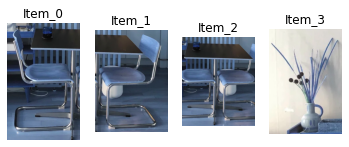

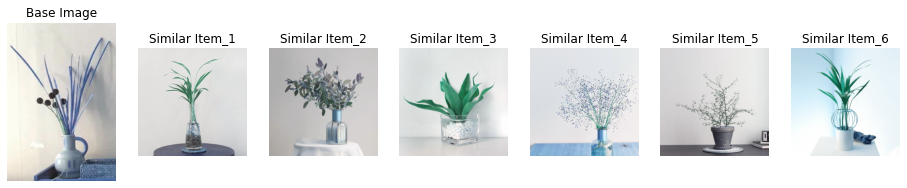

In [4]:
final_model('./datas/room_2.jpg')